In [1]:
from game import controlled_run

pygame 2.0.1 (SDL 2.0.14, Python 3.7.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import numpy as np
from game import DO_NOTHING
from game import JUMP

import matplotlib.pyplot as plt

import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from game import controlled_run

import random
import numpy as np
from collections import deque


In [3]:
games_count = 0
total_number_of_games = 20

# flaw in game design, it should be based on whether or not you make it past an opponent
class Wrapper(object):
    
    def __init__(self,dqn_solver,games=20):
        self.dqn_solver = dqn_solver
        self.scores=[]
        self.rewards=[]
        self.epoch = 0
        self.games=games
        controlled_run(self,0)
        
    def control(self,values):
        dqn_solver = self.dqn_solver
        if(values['closest_enemy']!=-1):
            state = [[values['closest_enemy']/1000]]
            action = dqn_solver.act(state)
            self.action = action
            self.old_values= values
        else:
            action=0
        return action
    
    def reward(self,old_values,new_values,action,score,done=False):
        import Enemy
        if(old_values['closest_enemy']!= -1):
            state = [[old_values['closest_enemy']/1000]]
            next_state = [[new_values['closest_enemy']/1000]]
            if(new_values['old_closest_enemy']+25 < 380 and new_values['old_closest_enemy']+25 != 24):
                reward = 2
                print("Rewarded for Jumping Over!")
            else:
                reward = 0#new_values['score_increased']
            
            if(done==True):
                reward=-1
                previous =  list(dqn_solver.memory[len(dqn_solver.memory)-1])
                previous[0] = previous[0]
                previous[1] = previous[1]
                previous[2]= reward
                previous[3] = next_state
                previous[4] = done
                previous = tuple(previous)
                dqn_solver.memory = dqn_solver.memory[0:(len(dqn_solver.memory)-1)]
                
                dqn_solver.memory.append(previous)

                # print(previous)

                print("Round: " + str(self.epoch) + " Score: " + str(score))
                # print(dqn_solver.memory[:-min(5,len(dqn_solver.memory))])

                dqn_solver.experience_replay()
            else:
                # print(state,action,reward,next_state,done)
                # print(dqn_solver.memory[:-5])
                dqn_solver.remember(state,action,reward,next_state,done)
                dqn_solver.experience_replay()
    def get_scores(self):
        return self.scores
    
    def get_rewards(self):
        return self.rewards

    def setPlayer(self,player):
        self.player = player

    def setEnemy(self,enemy):
        self.enemy = enemy
    
    def setCurrentScore(self,score):
        self.currentScore = score

    def gameover(self,score,values):
        self.scores.append(score)
        print(self.epoch)
        self.epoch+=1
        if(self.epoch < self.games):
            return controlled_run(self,self.epoch)

In [4]:
GAMMA = 0.5
ALPHA = 0.5
LR = 0.05
EPSILON = 0.99
EPS_DECAY = 0.95

class DQN:

    def __init__(self, observation_space, action_space):
        
        self.epsilon = EPSILON
        self.alpha = ALPHA
        self.gamma = GAMMA
        self.action_space = action_space
        self.observation_space = observation_space
        
        self.memory = []
        self.batch_size = 128

        # MODEL
        self.model = Sequential()
        self.model.add(Dense(16, input_shape=(observation_space,), kernel_initializer='he_normal'))
        self.model.add(LeakyReLU(0.1))
        self.model.add(Dense(32, kernel_initializer='he_normal'))
        self.model.add(LeakyReLU(0.1))
        self.model.add(Dense(8, kernel_initializer='he_normal'))
        self.model.add(LeakyReLU(0.2))
        self.model.add(Dropout(0.25))
        self.model.add(BatchNormalization())
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LR))
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            # print("RANDOM!")
            return random.randrange(self.action_space)
        q = self.model.predict(state)
        print("Measured: " + str(q[0]), state,np.argmax(q[0]))
        return np.argmax(q[0])

    def experience_replay(self):
        # print(self.memory,self.batch_size)
        import pandas as pd
    
        # organized_memory = pd.DataFrame([list(x) for x in self.memory])
        # organized_memory.columns = ['state','action','reward','next_state','done']
        # organized_memory['reward_abs'] = [abs(x) for x in organized_memory['reward']]
        # print(organized_memory['reward_abs'])
        # mem_sample=organized_memory.sample(n=min(len(self.memory),self.batch_size), weights='reward_abs').drop('rewards_abs',axis=1).values

        mem_sample = random.sample(self.memory, min(len(self.memory),self.batch_size))

        for state, action, reward, next_state, done in mem_sample:
            # print(state, action, reward, next_state, done)
            update_value = reward
            # print(update_value)
            if not done:
                # print("Discounting")
                update_value = self.alpha * (reward + self.gamma * np.max(self.model.predict(next_state)[0]))
            q = self.model.predict(state)
            if(update_value!=0):
                q[0][action] = update_value
            # print(state,type(state))
            # print(state,next_state,action,reward,q,done)
            self.model.train_on_batch(np.array(state), q)
        self.epsilon *= EPS_DECAY
        print("Epsilon: " + str(self.epsilon))

        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

In [5]:
dqn_solver = DQN(1,2)
game = Wrapper(dqn_solver,50)

Epsilon: 0.9405
Epsilon: 0.8934749999999999
Epsilon: 0.8488012499999998
Epsilon: 0.8063611874999999
Measured: [ 2.0388865 -1.2433622] [[0.637]] 0
Epsilon: 0.7660431281249999
Epsilon: 0.7277409717187499
Rewarded for Jumping Over!
Epsilon: 0.6913539231328123
Epsilon: 0.6567862269761716
Measured: [2.5439668 0.8955996] [[0.385]] 0
Epsilon: 0.623946915627363
Round: 0 Score: 6
Epsilon: 0.5927495698459949
0
Epsilon: 0.5631120913536951
Epsilon: 0.5349564867860104
Epsilon: 0.5082086624467098
Measured: [ 0.1978328  -0.12187024] [[0.517]] 0
Epsilon: 0.4827982293243743
Measured: [0.05997244 0.10467621] [[0.361]] 1
Epsilon: 0.45865831785815553
Measured: [ 0.8430073  -0.69648993] [[0.997]] 0
Epsilon: 0.4357254019652477
Measured: [ 0.47375345 -0.44398835] [[0.841]] 0
Epsilon: 0.41393913186698533
Measured: [ 0.06499899 -0.24947949] [[0.685]] 0
Epsilon: 0.39324217527363603
Measured: [-0.21253571  0.08053075] [[0.529]] 1
Epsilon: 0.37358006650995423
Measured: [-0.710787    0.81495345] [[0.22]] 1
Rewarde

Measured: [-2.260839  2.298396] [[1.0]] 1
Epsilon: 0.0025797249743770246
Measured: [-0.78624266 -0.11711704] [[0.721]] 1
Epsilon: 0.0024507387256581734
Measured: [-0.39444605 -2.7236972 ] [[0.412]] 0
Epsilon: 0.0023282017893752646
Measured: [ 0.27662534 -3.7495594 ] [[0.256]] 0
Round: 13 Score: 2
Epsilon: 0.002211791699906501
13
Measured: [-0.7706245  1.2894802] [[1.0]] 1
Epsilon: 0.002101202114911176
Measured: [-0.53154325  1.31908   ] [[1.0]] 1
Epsilon: 0.0019961420091656173
Measured: [-0.55246854  1.49826   ] [[1.0]] 1
Epsilon: 0.0018963349087073363
Measured: [-0.7098292  1.3470683] [[1.0]] 1
Epsilon: 0.0018015181632719695
Measured: [-0.29504493 -0.24180394] [[0.715]] 1
Epsilon: 0.001711442255108371
Measured: [ 0.5683089 -2.2077327] [[0.406]] 0
Epsilon: 0.0016258701423529523
Measured: [-0.20454401 -2.2874277 ] [[0.25]] 0
Round: 14 Score: 2
Epsilon: 0.0015445766352353047
14
Measured: [-1.692549    0.14757612] [[1.0]] 1
Epsilon: 0.0014673478034735394
Measured: [-1.2025855   0.47520593

Epsilon: 1.6923365198032738e-05
23
Measured: [-6.9381847  0.9674551] [[1.0]] 1
Epsilon: 1.60771969381311e-05
Measured: [4.8119493 4.77526  ] [[1.0]] 0
Epsilon: 1.5273337091224543e-05
Measured: [-1.800343  6.816419] [[1.0]] 1
Epsilon: 1.4509670236663315e-05
Measured: [-4.8762155  -0.30823296] [[0.79]] 1
Epsilon: 1.3784186724830148e-05
Measured: [ 0.1461801  -0.73865473] [[0.481]] 0
Epsilon: 1.309497738858864e-05
Measured: [-1.4089692 -1.3622227] [[0.325]] 1
Rewarded for Jumping Over!
Epsilon: 1.2440228519159207e-05
Measured: [-3.500372   1.4990187] [[0.787]] 1
Epsilon: 1.1818217093201246e-05
Measured: [-0.44346648 -1.2283998 ] [[0.478]] 0
Epsilon: 1.1227306238541183e-05
Measured: [ 0.61026955 -3.7058437 ] [[0.322]] 0
Rewarded for Jumping Over!
Epsilon: 1.0665940926614124e-05
Measured: [-0.29904085 -5.02327   ] [[0.166]] 0
Rewarded for Jumping Over!
Round: 24 Score: 6
Epsilon: 1.0132643880283417e-05
24
Measured: [3.0886436 3.9590387] [[1.0]] 1
Epsilon: 9.626011686269246e-06
Measured: [-0

Measured: [4.483972  1.3943678] [[1.0]] 0
Epsilon: 1.1686284083549937e-07
Measured: [2.0774674 1.0295874] [[0.946]] 0
Epsilon: 1.110196987937244e-07
Measured: [2.3785143 0.9663501] [[0.79]] 0
Epsilon: 1.0546871385403817e-07
Measured: [2.6532483 0.5217862] [[0.634]] 0
Epsilon: 1.0019527816133625e-07
Measured: [-1.1624048 -0.4428239] [[0.478]] 1
Epsilon: 9.518551425326943e-08
Measured: [ 3.6569736 -6.250623 ] [[0.169]] 0
Round: 34 Score: 11
Epsilon: 9.042623854060595e-08
34
Measured: [-18.187248    6.9856076] [[1.0]] 1
Epsilon: 8.590492661357564e-08
Measured: [-12.594018  10.638063] [[1.0]] 1
Epsilon: 8.160968028289686e-08
Measured: [-7.4658694  6.0994573] [[1.0]] 1
Epsilon: 7.752919626875202e-08
Measured: [0.08185282 1.1794072 ] [[0.703]] 1
Epsilon: 7.365273645531441e-08
Measured: [ 8.874246  -4.9514084] [[0.394]] 0
Epsilon: 6.997009963254868e-08
Measured: [ 13.694473 -10.758088] [[0.238]] 0
Round: 35 Score: 2
Epsilon: 6.647159465092125e-08
35
Measured: [-6.4106092  4.4071627] [[0.955]]

Epsilon: 8.069862824759475e-10
Measured: [-5.9027042 -2.7880633] [[0.235]] 1
Rewarded for Jumping Over!
Epsilon: 7.666369683521501e-10
Measured: [-0.01460326 -0.02560412] [[0.688]] 0
Epsilon: 7.283051199345426e-10
Measured: [-1.8067023 -0.8641397] [[0.532]] 1
Epsilon: 6.918898639378155e-10
Measured: [-4.5389476 -1.9651866] [[0.223]] 1
Rewarded for Jumping Over!
Epsilon: 6.572953707409247e-10
Measured: [1.5079185 0.5199455] [[1.0]] 0
Epsilon: 6.244306022038785e-10
Measured: [1.7654041 0.6698112] [[1.0]] 0
Epsilon: 5.932090720936846e-10
Measured: [2.3067648  0.81027836] [[1.0]] 0
Epsilon: 5.635486184890003e-10
Measured: [1.1974273  0.49769905] [[0.865]] 0
Epsilon: 5.353711875645502e-10
Measured: [-0.6295997  -0.29509437] [[0.709]] 1
Epsilon: 5.086026281863227e-10
Measured: [-2.340129  -1.0938908] [[0.4]] 1
Round: 45 Score: 26
Epsilon: 4.831724967770065e-10
45
Measured: [1.886175  0.7027847] [[1.0]] 0
Epsilon: 4.5901387193815616e-10
Measured: [1.7541854 1.0073124] [[1.0]] 0
Epsilon: 4.360

In [6]:
scores = game.get_scores()

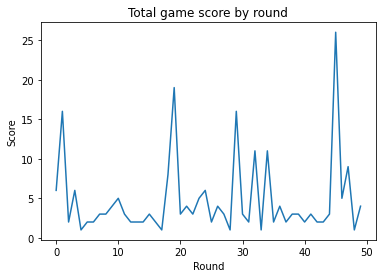

In [7]:
plt.plot(scores)
plt.xlabel('Round')
plt.ylabel('Score')
plt.title('Total game score by round')
plt.show()

In [8]:
scores_start = scores[:50]

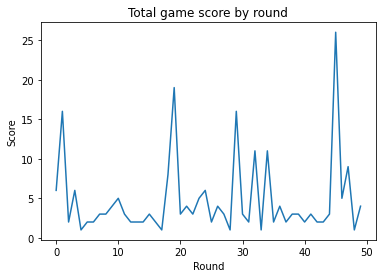

In [9]:
plt.plot(scores_start)
plt.xlabel('Round')
plt.ylabel('Score')
plt.title('Total game score by round')
plt.show()

In [10]:
rewards = np.array(game.get_rewards()).T

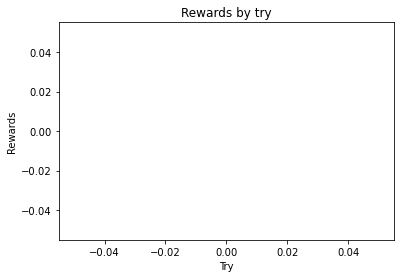

In [11]:
plt.plot(rewards)
plt.xlabel('Try')
plt.ylabel('Rewards')
plt.title('Rewards by try')
plt.show()